# Autoencoders

In [1]:
import tensorflow as tf
tf.VERSION

'1.13.1'

In [5]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np


This is a short bash shell script to check if you have downloaded the required data i.e. mnist.npz. If so, it prints out a confirmation message. If not, it downloads the data.

# Download Data

In [6]:
%%bash
FILE=mnist.npz
if test -f "$FILE"; then
  echo "$FILE exists"
else 
  wget -q https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
fi

In [7]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [8]:
(x_train, y_train), (x_test, y_test) = load_data('./mnist.npz')

In [9]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Autoencoder Model 1

Below is an example of a simple autoencoder that first maps the 784 dimensional input image to a 32 dimensional latent representation and then attempts to reconstruct the 784 dimensional input image from the 32 dimensional encoded representation. 

In [10]:
latent_dim = 32

## input layer
input_layer = Input(shape=(784,))

## latent view
latent_view   = Dense(latent_dim, activation='relu')(input_layer)

## decoding architecture

## output layer
output_layer  = Dense(784)(latent_view)

autoencoder = Model(input_layer, output_layer)



Instructions for updating:
Colocations handled automatically by placer.


We can also define the encoder and decoder as individual models 

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Training for 50 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=2048, validation_data=(x_test, x_test), callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0907 - val_loss: 0.0666
Epoch 2/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0614 - val_loss: 0.0559
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0507 - val_loss: 0.0449
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0420 - val_loss: 0.0388
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0374 - val_loss: 0.0354
Epoch 6/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0345 - val_loss: 0.0329
Epoch 7/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0321 - val_loss: 0.0302
Epoch 8/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0295 - val_loss: 0.0280
Epoch 9/50
60000/60000 [==============================] - 1s 1

In [13]:
decoded_imgs = autoencoder.predict(x_test)

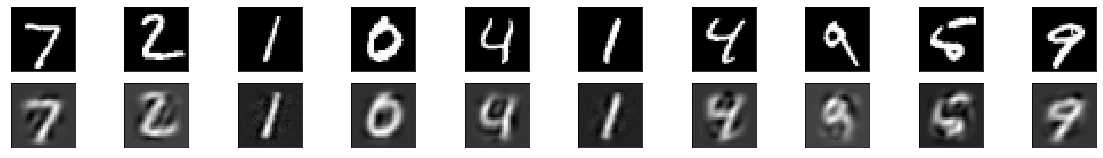

In [14]:
# using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Applications

There are many applications to autoencoders.

## Image Compression

To see how autoencoders can be used to compress images, it is easier to define the encoder and decoder halves of the autoencoder as individual models.

In [15]:
latent_dim = 36

inputs = Input(shape=(784,), name='encoder_input')
latent_view = Dense(latent_dim, name='latent_vector')(inputs)

# Instantiate Encoder Model
encoder = Model(inputs, latent_view, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
decoded = Dense(784)(latent_inputs)

# Instantiate Decoder Model
decoder = Model(latent_inputs, decoded, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
latent_vector (Dense)        (None, 36)                28260     
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 36)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               29008     
Total params: 29,008
Trainable params: 29,008
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

In [16]:
# Training for 50 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=2048, validation_data=(x_test, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 9us/step - loss: 0.0887 - val_loss: 0.0632
Epoch 2/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0574 - val_loss: 0.0499
Epoch 3/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0445 - val_loss: 0.0393
Epoch 4/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0368 - val_loss: 0.0338
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0323 - val_loss: 0.0300
Epoch 6/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0289 - val_loss: 0.0269
Epoch 7/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0261 - val_loss: 0.0245
Epoch 8/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0240 - val_loss: 0.0227
Epoch 9/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0224 - val_loss: 0.0213
Epoch 1

In [17]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

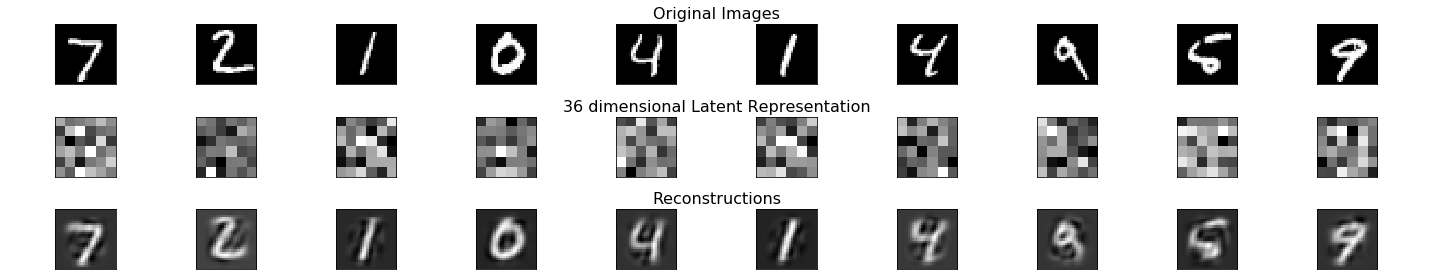

In [18]:
n = 10 # how many images we will display
#plt.figure(figsize=(20, 4))
fig, axes = plt.subplots( figsize=(20,4) , nrows=3, ncols=1, sharey=False) 
axes[0].set_title('Original Images', fontsize=16)
axes[0].axis('off')
axes[1].set_title('36 dimensional Latent Representation', fontsize=16)
axes[1].axis('off')
axes[2].set_title('Reconstructions', fontsize=16)
axes[2].axis('off')


for i in range(n):
    # display original
    ax = fig.add_subplot(3, n, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
    
    
    # display encoding
    ax = fig.add_subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = fig.add_subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig.tight_layout()
plt.show()

## Denoising

In [19]:
# Reshape the train and test array for augmenter
x_train = x_train.reshape(-1, 28, 28, 1)  # becomes of shape (60000, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)    # becomes of shape (10000, 28, 28, 1)
  
noise = augmenters.SaltAndPepper(0.6)
seq_object = augmenters.Sequential([noise])

x_train_n = seq_object.augment_images(x_train * 255) / 255
x_test_n = seq_object.augment_images(x_test * 255) / 255

Before we add noise, the images look like this.

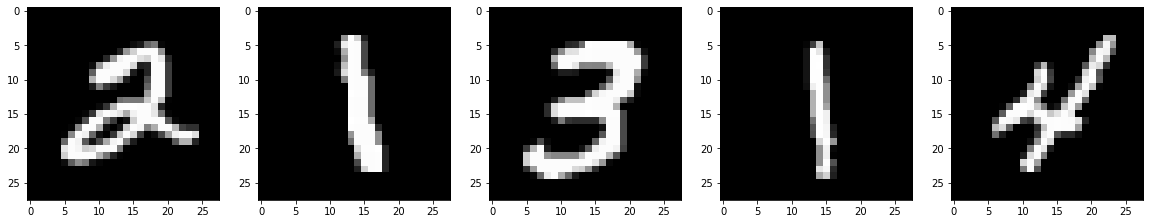

In [20]:
f, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols=5)
for i in range(5,10):
    ax[i-5].imshow(x_train[i].reshape(28, 28))
plt.show()

After we add noise, the images look like this.

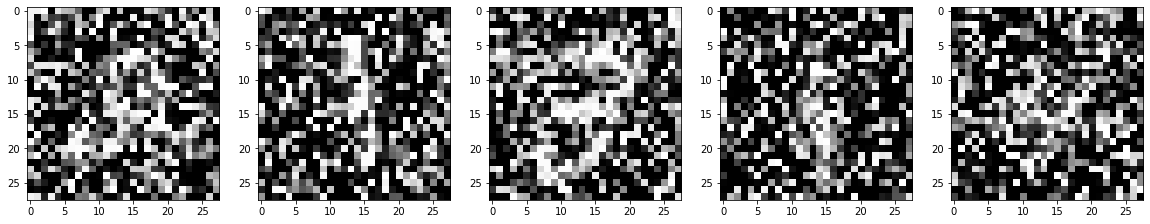

In [21]:
f, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols=5)
for i in range(5,10):
    ax[i-5].imshow(x_train_n[i].reshape(28, 28))
plt.show()

For our denoising autoencoder, we will need a more sophisticated architecture of Conv2D and MaxPool2D layers.

## Autoencoder Model 2

In [22]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
denoise_autoencoder = Model(input_layer, output_layer)
denoise_autoencoder.compile(optimizer='adam', loss='mse')

In [23]:
denoise_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = denoise_autoencoder.fit(x_train_n, x_train, epochs=10, batch_size=2048, validation_data=(x_test_n, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 240us/step - loss: 0.0763 - val_loss: 0.0682
Epoch 2/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0645 - val_loss: 0.0613
Epoch 3/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0562 - val_loss: 0.0528
Epoch 4/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0509 - val_loss: 0.0491
Epoch 5/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.0477 - val_loss: 0.0459
Epoch 6/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.0450 - val_loss: 0.0433
Epoch 7/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0429 - val_loss: 0.0414
Epoch 8/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0411 - val_loss: 0.0399
Epoch 9/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.0397 - val_loss: 0.

In [25]:
preds = denoise_autoencoder.predict(x_test_n[:10])

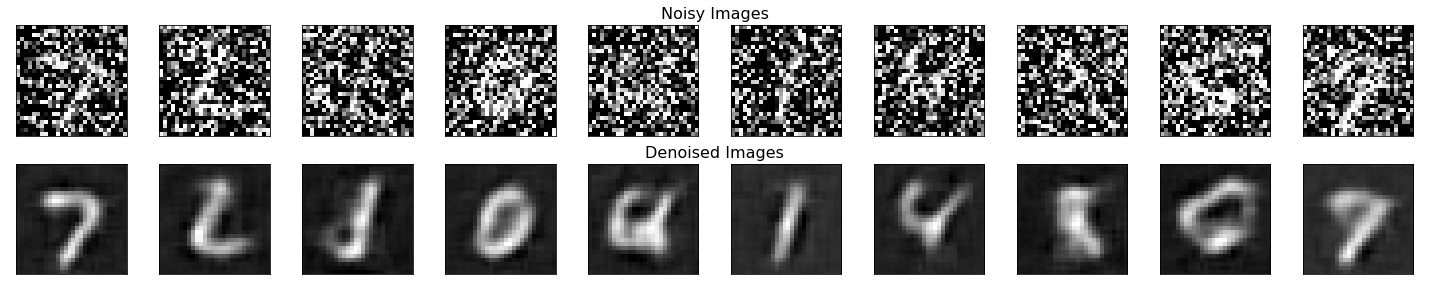

In [26]:
n = 10 # how many images we will display
fig, axes = plt.subplots( figsize=(20,4) , nrows=2, ncols=1, sharey=False) 
axes[0].set_title('Noisy Images', fontsize=16)
axes[0].axis('off')
axes[1].set_title('Denoised Images', fontsize=16)
axes[1].axis('off')



for i in range(n):
    # display noisy images
    ax = fig.add_subplot(2, n, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_n[i].reshape(28, 28))
    plt.gray()
    
    # display denoised images
    ax = fig.add_subplot(2, n, i + 1 + n)
    plt.imshow(preds[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()